<a href="https://colab.research.google.com/github/mrunaliyadav003/AI-ML/blob/main/Farm_Pest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install keras-tuner

In [14]:
# Management Modules
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter

# Data loading and transformation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-trained models
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception

# Model Layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Model Hyertunig and Metrices
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# Set up random seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Specify the root file path
directory_path = "/content/drive/MyDrive/farm insect detect/farm_insects"
N_CLASSES = 15
IMAGE_SIZE = (224, 224, 3)


def create_callbacks(name, patience):
    """
    Create a list of callbacks for model training.

    Parameters:
        name (str): Name of the model for saving purposes.
        patience (int): Number of epochs to wait for improvement in validation loss.

    Returns:
        list: List of callbacks including EarlyStopping and ModelCheckpoint.
    """
    return [
        EarlyStopping(patience=patience, restore_best_weights=True, verbose=1),
        ModelCheckpoint(name + ".h5", save_best_only=True, monitor="val_loss")
    ]


# Collect the class names
class_names = os.listdir(directory_path)

# Show the information
print(f"Number of Classes: {N_CLASSES}")
print("Class Names:")
for index, name in enumerate(class_names):
    print(f"{index + 1:2}. {name}")

# Compute the sample size for each class
class_sample_size = []
for class_name in class_names:
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):
        file_names = os.listdir(class_path)
        class_sample_size.append(len(file_names))
    else:
        print(f"Invalid directory path: {class_path}")

# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images * 100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

Number of Classes: 15
Class Names:
 1. Thrips
 2. Corn Earworms
 3. Fall Armyworms
 4. Tomato Hornworms
 5. Corn Borers
 6. Spider Mites
 7. Western Corn Rootworms
 8. Citrus Canker
 9. Colorado Potato Beetles
10. Fruit Flies
11. Brown Marmorated Stink Bugs
12. Aphids
13. Cabbage Loopers
14. Armyworms


In [17]:
# Calculate the total number of images
total_n_images = sum(class_sample_size)

# Calculate the percentage of sample size for each class
percentage_sample_size = [value / total_n_images * 100 for value in class_sample_size]

# Sort the class sample sizes in descending order
sorted_class_sample_size = sorted(class_sample_size, reverse=True)

# Display the class names, data size, percentage, and rank
class_distribution_df = pd.DataFrame({
    "Class Names": class_names,
    "Data Size": class_sample_size,
    "Percentage(%)": percentage_sample_size
})

In [18]:
# Calculate the rank of each class based on data size
class_distribution_df["Rank"] = class_distribution_df["Data Size"].rank(
    method="dense", ascending=False)

# Show the data
class_distribution_df

Class Names  Data Size  Percentage(%)  Rank
0                        Thrips        109       7.290970   7.0
1                 Corn Earworms        110       7.357860   6.0
2                Fall Armyworms        113       7.558528   4.0
3              Tomato Hornworms        109       7.290970   7.0
4                   Corn Borers        116       7.759197   2.0
5                  Spider Mites        119       7.959866   1.0
6        Western Corn Rootworms        100       6.688963  10.0
7                 Citrus Canker        104       6.956522   8.0
8       Colorado Potato Beetles        112       7.491639   5.0
9                   Fruit Flies        101       6.755853   9.0
10  Brown Marmorated Stink Bugs        114       7.625418   3.0
11                       Aphids         88       5.886288  12.0
12              Cabbage Loopers        104       6.956522   8.0
13                    Armyworms         96       6.421405  11.0

In [19]:
# Visualize the class distribution
fig = px.bar(
    data_frame=class_distribution_df,
    x="Class Names",
    y="Data Size",
    text="Data Size",
    hover_data=["Percentage(%)", "Rank"],
    title="Class Distribution of Insects in the Dataset",
    color_discrete_sequence=px.colors.qualitative.D3,
    height=600,
)

# Set axis labels and adjust layout
fig.update_layout(
    xaxis_title="Class Names",
    yaxis_title="Data Size",
    yaxis_tickformat="d",
    yaxis=dict(showgrid=False),
    showlegend=False,
)

# Show the plot
fig.show()

In [20]:
# Computer class weights.
class_weights = [total_n_images / (N_CLASSES * class_samples)
                 for class_samples in class_sample_size]

# Add this data into the data frame
class_distribution_df["Class Weights"] = class_weights

# Show the updated data
class_distribution_df

Class Names  Data Size  Percentage(%)  Rank  Class Weights
0                        Thrips        109       7.290970   7.0       0.914373
1                 Corn Earworms        110       7.357860   6.0       0.906061
2                Fall Armyworms        113       7.558528   4.0       0.882006
3              Tomato Hornworms        109       7.290970   7.0       0.914373
4                   Corn Borers        116       7.759197   2.0       0.859195
5                  Spider Mites        119       7.959866   1.0       0.837535
6        Western Corn Rootworms        100       6.688963  10.0       0.996667
7                 Citrus Canker        104       6.956522   8.0       0.958333
8       Colorado Potato Beetles        112       7.491639   5.0       0.889881
9                   Fruit Flies        101       6.755853   9.0       0.986799
10  Brown Marmorated Stink Bugs        114       7.625418   3.0       0.874269
11                       Aphids         88       5.886288  12.0       1.132576
12              Cabbage Loopers        104       6.956522   8.0       0.958333
13                    Armyworms         96       6.421405  11.0       1.038194

In [21]:
!pip install -U scikit-learn

In [22]:
# Initialize empty lists to collect image paths and class labels
all_image_paths = []
class_labels = []

# Collect all image paths and corresponding class labels
for class_name in class_names:
    class_path = os.path.join(directory_path, class_name)
    if os.path.isdir(class_path):
        paths = glob(os.path.join(class_path, "*"))  # Search for all files within the class directory
        all_image_paths.extend(paths)
        class_labels.extend([class_name] * len(paths))
    else:
        print(f"Invalid directory path: {class_path}")

# Check if any image paths were collected
if not all_image_paths:
    print("No image paths were found. Please check the directory path and ensure it contains image files.")
    # Add appropriate error handling or exit the program if needed.

# Perform stratified data split
train_images, valid_test_images = train_test_split(
    all_image_paths, train_size=0.9, test_size=0.1, stratify=class_labels)

valid_images, test_images = train_test_split(
    valid_test_images, train_size=0.9, test_size=0.1)

In [23]:
# Extract class labels for trained images
trained_class_labels = [os.path.split(path)[0].split("/")[-1] for path in train_images]

# Compute class distribution
class_distribution = dict(Counter(trained_class_labels))

# Compute class weights
total_trained_images = len(train_images)
train_class_weights = {class_label: total_trained_images /
                       (N_CLASSES * class_samples) for class_label, class_samples in class_distribution.items()}

# Display the class weights of the training images
print(f"  Class Name {' '*27} Train Class Weight {' '} Original Class Weights")
for index, (name, weight) in enumerate(train_class_weights.items()):
    original_weight = class_distribution_df[class_distribution_df["Class Names"]
                                            == name]["Class Weights"].values[0]
    print(f"{index+1:2}. {name:40} {weight:.3f} {original_weight:25.3f}")

  Class Name                             Train Class Weight   Original Class Weights
 1. Citrus Canker                            0.954                     0.958
 2. Western Corn Rootworms                   0.996                     0.997
 3. Fruit Flies                              0.985                     0.987
 4. Colorado Potato Beetles                  0.888                     0.890
 5. Fall Armyworms                           0.879                     0.882
 6. Cabbage Loopers                          0.954                     0.958
 7. Spider Mites                             0.838                     0.838
 8. Corn Borers                              0.862                     0.859
 9. Brown Marmorated Stink Bugs              0.879                     0.874
10. Tomato Hornworms                         0.915                     0.914
11. Corn Earworms                            0.906                     0.906
12. Thrips                                   0.915                  

In [26]:
class FarmInsects:
    """
    A class for loading and processing farm insect images dataset.
    """

    def __init__(self, class_names: list, n_classes: int, image_size: tuple = (256, 256, 3)):
        """
        Initialize FarmInsects class.

        Args:
            class_names (list): List of class names.
            n_classes (int): Number of classes.
            image_size (tuple): Size of the images (height, width, channels).
        """
        self.image_size = image_size
        self.class_names = class_names
        self.n_classes = n_classes

    def load_image(self, image_path: str) -> tf.Tensor:
        """
        Load and preprocess an image.

        Args:
            image_path (str): Path to the image file.

        Returns:
            tf.Tensor: Preprocessed image tensor.
        """
        image_file = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_file, channels=3)
        image = tf.image.resize(image, self.image_size[:2])
        image = image / 255.

        return image

    def extract_label(self, image_path: str, names: bool = False) -> int or str:
        """
        Extract the label from the image path.

        Args:
            image_path (str): Path to the image file.
            names (bool): Whether to return class names or numerical labels.

        Returns:
            int or str: Numerical label or class name.
        """
        name = os.path.split(image_path)[0].split("/")[-1]
        if names:
            return name
        else:
            label = self.class_names.index(name)
            return label

    def load_data(self, image_paths: list, desc: str = "Loading", one_hot: bool = True, names: bool = False) -> tuple:
        """
        Load the images and labels from the given image paths.

        Args:
            image_paths (list): List of image paths.
            desc (str): Description for tqdm progress bar.
            one_hot (bool): Whether to use one-hot encoding for labels.
            names (bool): Whether to return class names instead of numerical labels.

        Returns:
            tuple: Tuple containing the loaded images and labels.
        """
        self.images = np.empty((len(image_paths),) + self.image_size, dtype=np.float32)

        if names:
            self.labels = []
        else:
            self.labels = np.empty((len(image_paths),), dtype=np.int32)

        for index, path in tqdm(enumerate(image_paths), desc=desc):
            image = self.load_image(image_path=path)
            label = self.extract_label(image_path=path, names=names)
            self.images[index] = image

            if names:
                self.labels.append(label)
            else:
                self.labels[index] = label

        if one_hot and not names:
            one_hot_labels = tf.one_hot(self.labels, depth=self.n_classes)
            return self.images, one_hot_labels
        else:
            return self.images, self.labels

    def show_random_images(self, grid: tuple, image_paths: list, figsize: tuple = (25, 20)):
        """
        Display random images from the given image paths.

        Args:
            grid (tuple): Tuple specifying the grid size (number of rows, number of columns).
            image_paths (list): List of image paths.
            figsize (tuple): Figure size for displaying the images.
        """
        n_rows, n_cols = grid
        n_images = n_rows * n_cols

        image_indexes = np.random.randint(0, len(image_paths), size=n_images)
        image_paths = np.take(image_paths, image_indexes)

        images, labels = self.load_data(image_paths=image_paths, one_hot=False, names=True)

        plt.figure(figsize=figsize)

        for plot_index in range(1, n_images + 1):
            plt.subplot(n_rows, n_cols, plot_index)
            plt.imshow(images[plot_index - 1])
            plt.title(label=labels[plot_index - 1])
            plt.axis('off')

        plt.show()

In [31]:

# Filter directories from image_paths list
train_image_files = [path for path in train_images if os.path.isfile(path)]
test_image_files = [path for path in test_images if os.path.isfile(path)]
valid_image_files = [path for path in valid_images if os.path.isfile(path)]

# Load Training Data
trainXs, trainYs = farm_data.load_data(image_paths=train_image_files, desc="Training Data")

# Load testing Data
testXs, testYs = farm_data.load_data(image_paths=test_image_files, desc="Testing Data")

# Load validation Data
validXs, validYs = farm_data.load_data(image_paths=valid_image_files, desc="Validation Data")

Training Data: 1344it [00:24, 54.59it/s]
Testing Data: 15it [00:00, 98.15it/s] 
Validation Data: 135it [00:02, 56.99it/s]


Loading: 25it [00:00, 79.78it/s]


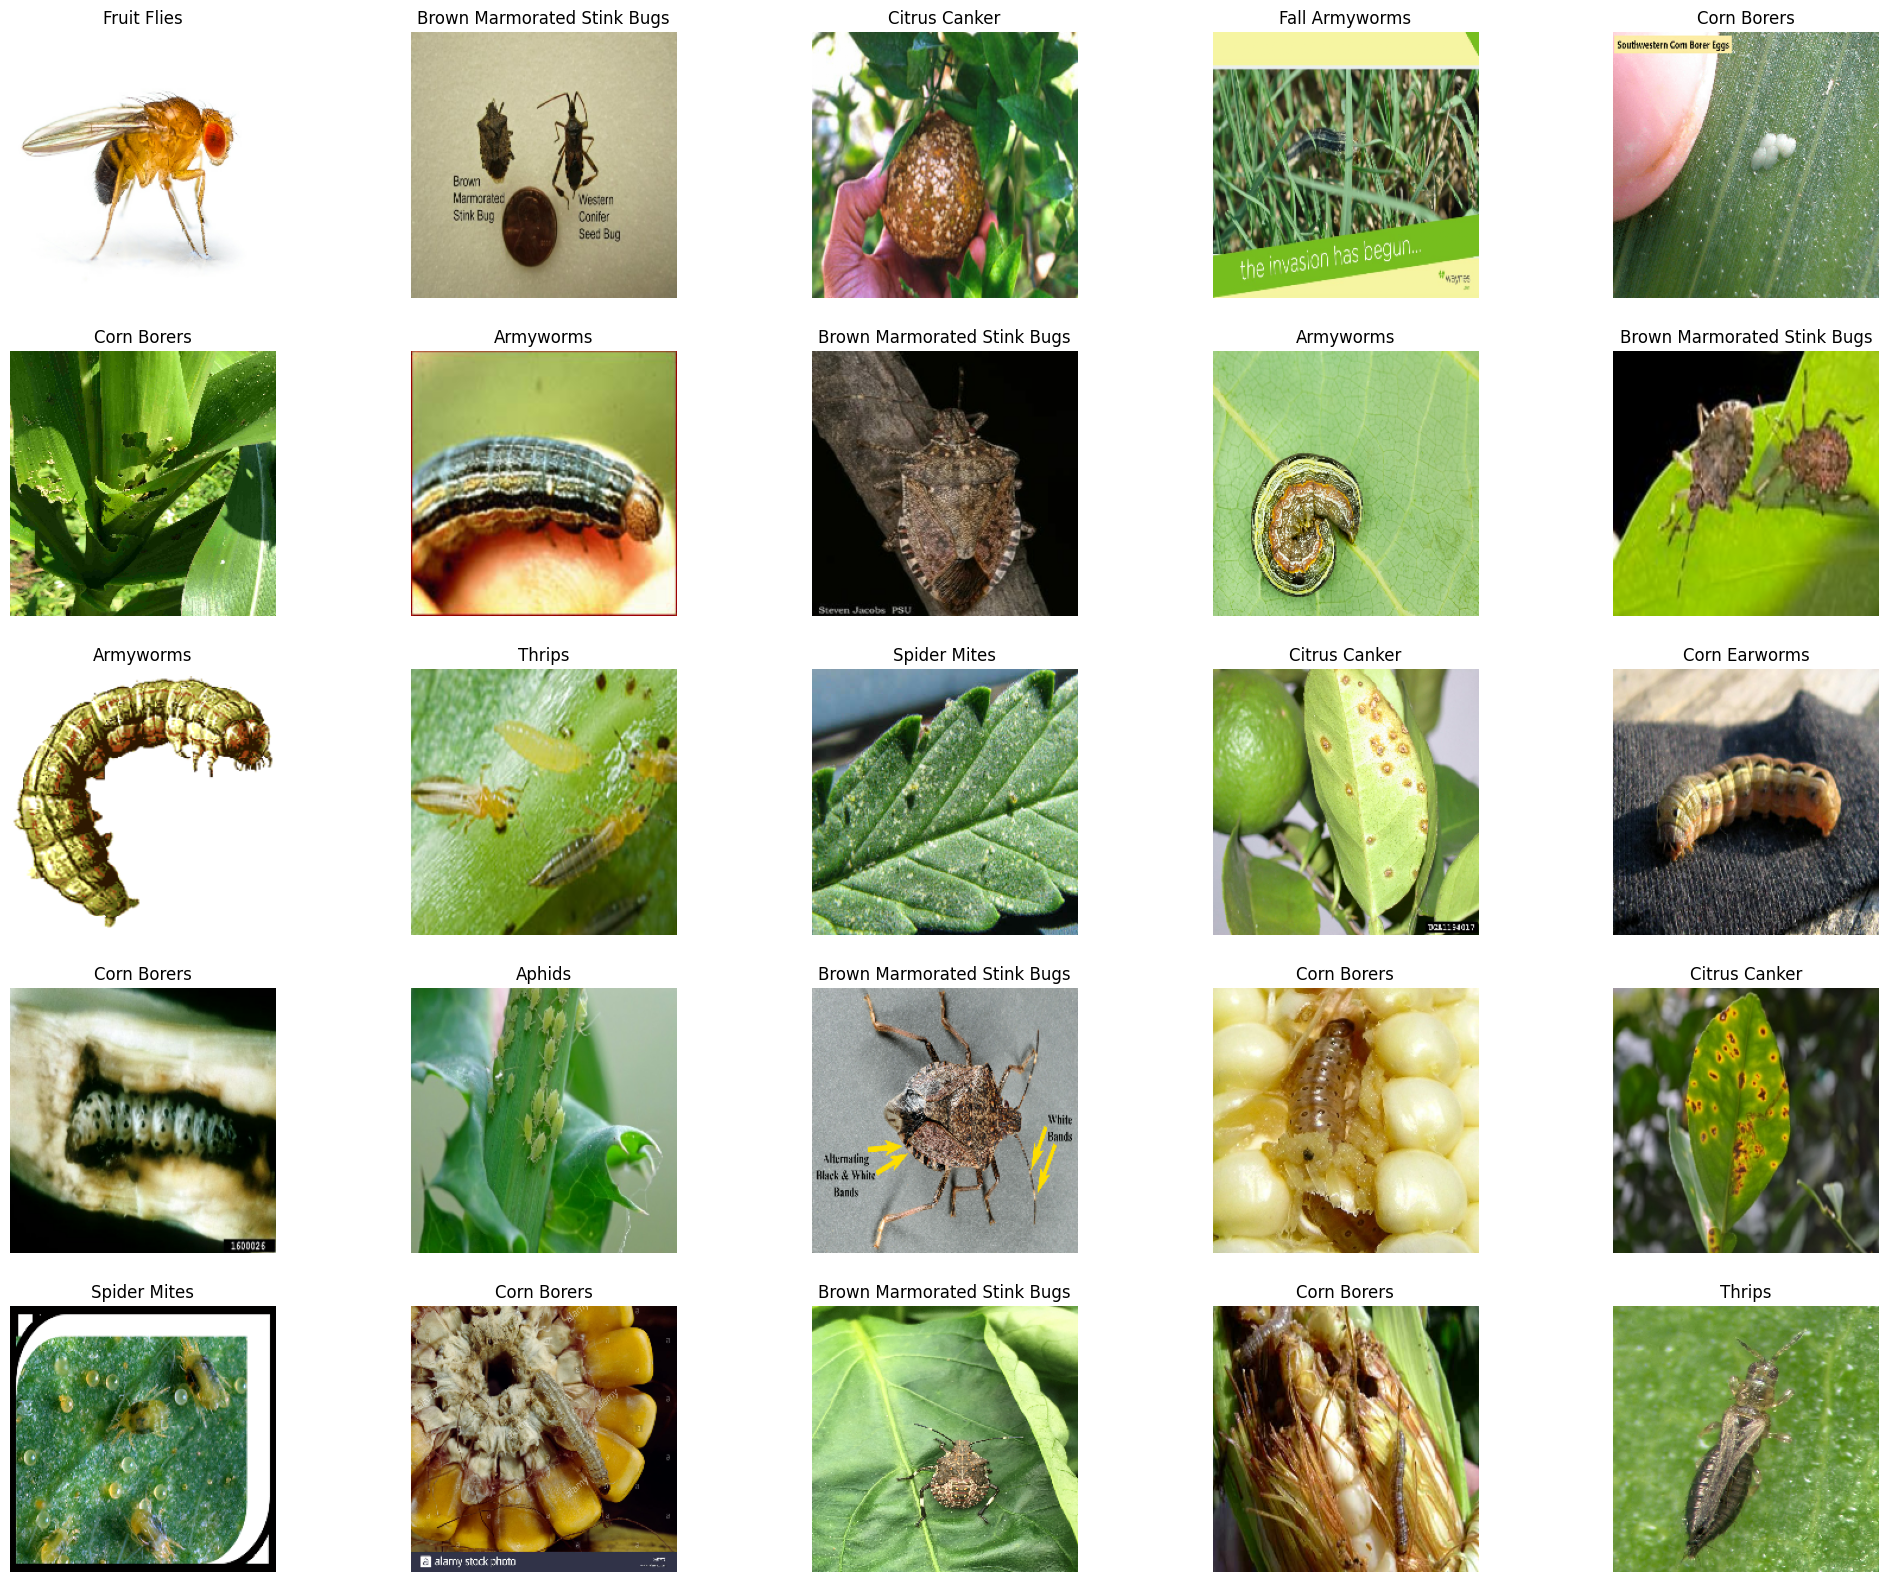

In [32]:
# Using in-built method
farm_data.show_random_images(image_paths=train_images, grid=(5,5))

**Backbone Selection**

Given the limited number of available images, we will adopt a transfer learning approach, which offers significant advantages in capturing relevant features present in the farm insects. This approach allows us to leverage pre-trained models, such as ResNet, MobileNet, VGG, and others, that have demonstrated exceptional performance on various tasks. Our goal is to identify the most suitable network architecture for our specific classification task.

To accomplish this, we will conduct a systematic evaluation of these models by assessing their accuracy, F1 score, precision, recall, and loss metrics. Through this evaluation, we aim to select the model that achieves the best performance on our dataset. In order to facilitate this process, we will create a class object that encompasses functions for model training, model visualization, and model comparison.

Similar to our previous class object for handling the dataset, this new class object will streamline the model training process and enable us to effectively compare different models. By leveraging the strengths of these pre-trained networks, we can enhance the accuracy and efficiency of our classification task, despite the limited availability of data

In [33]:
# Converting the class weights from a list to dictionary
class_weights_dict = dict(zip(range(N_CLASSES), class_distribution_df["Class Weights"]))

In [34]:
class Model:
    models = [
        ResNet50V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        ResNet152V2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        MobileNetV2(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
        Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE),
    ]

    model_names = [
        "ResNet50V2",
        "ResNet152V2",
        "MobileNetV2",
        "Xception"
    ]

    def __init__(self, model_name: str):
        """
        Initialize the Model class with the specified pre-trained model.

        Args:
            model_name (str): Name of the pre-trained model to be used.
        """
        self.model_name = model_name
        self.index = self.model_names.index(model_name)
        self.backbone = self.models[self.index]

    def train(self, trainXs, trainYs, validation_data, epochs=10, batch_size=32, verbose=1):
        """
        Train the model using the specified training and validation data.

        Args:
            trainXs (numpy.ndarray): Training images.
            trainYs (numpy.ndarray): Training labels.
            validation_data: Validation data as a tuple (valXs, valYs).
            epochs (int): Number of epochs to train the model.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training logs (0, 1, or 2).
        """
        self.backbone.trainable = False

        self.model = Sequential([
            self.backbone,
            GlobalAveragePooling2D(),
            Dropout(0.4),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])

        self.model.compile(
            loss="categorical_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )

        self.history = self.model.fit(
            trainXs, trainYs,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights_dict,
            steps_per_epoch=len(trainXs)//batch_size,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=verbose
        )

    def visualize_training(self):
        """
        Visualize the training history.
        """
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"{self.model_name} Training Curve")

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label="Loss", color="g")
        plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (crossentropy)")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
        plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.legend()

        plt.show()

    def evaluate(self, testXs, testYs, verbose=1, visualize=False):

        test_loss, test_acc = self.model.evaluate(testXs, testYs, verbose=verbose)

        if visualize:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{self.model_name} Performance Check")
            plt.subplot(1, 2, 1)
            plt.plot(self.history.history['loss'], label="Loss", color="g")
            plt.plot(self.history.history['val_loss'], label="Val Loss", color="b")
            plt.axhline(test_loss, color='black', alpha=0.8, linestyle="--", label="Test Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss (crossentropy)")
            plt.grid()
            plt.ylim([0, 1.5])
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.history.history['accuracy'], label="Accuracy", color="g")
            plt.plot(self.history.history['val_accuracy'], label="Val Accuracy", color="b")
            plt.axhline(test_acc, color='black', alpha=0.8, linestyle="--", label="Test Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0.4, 1.0])
            plt.grid()
            plt.legend()

            plt.show()
        else:
            return test_loss, test_acc

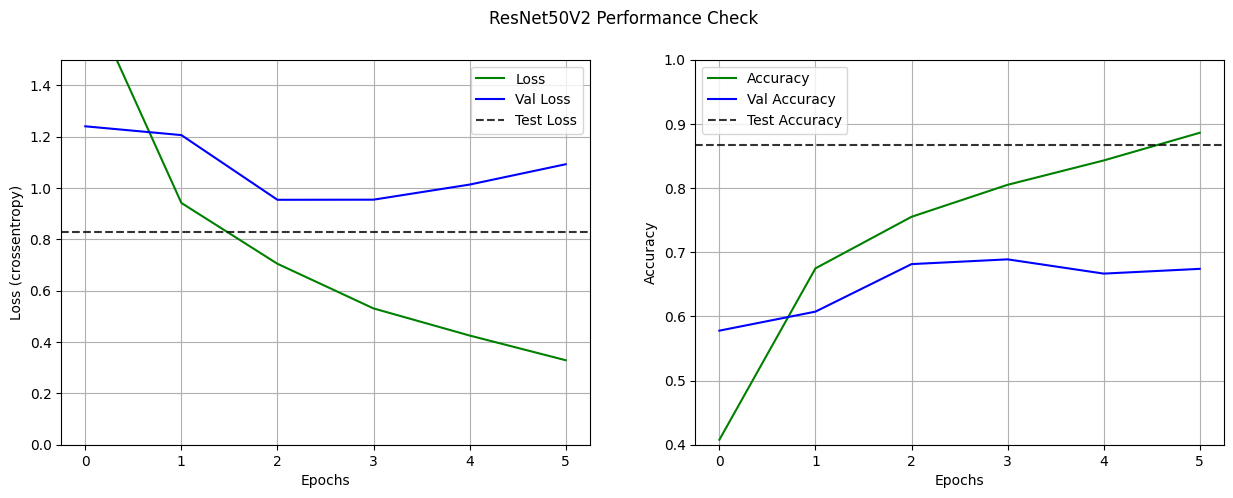

In [36]:
# Initialize the ResNet50V2 model
resnet50_model = Model(model_name="ResNet50V2")

# Train the model
resnet50_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet50_model.evaluate(testXs, testYs, visualize=True, verbose=0)

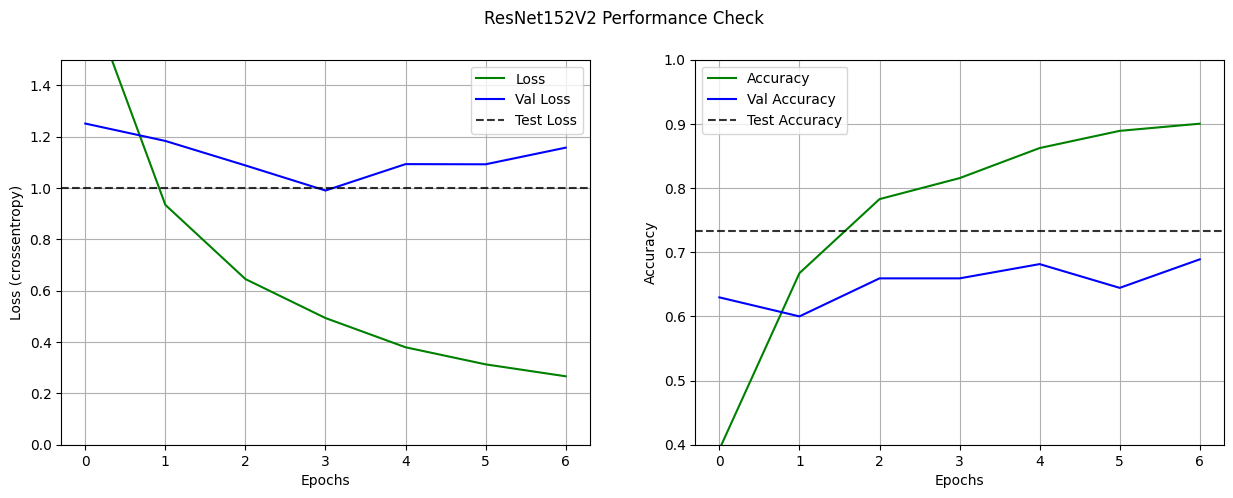

In [37]:
# Initialize the ResNet152V2 model
resnet152_model = Model(model_name="ResNet152V2")

# Train the model
resnet152_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
resnet152_model.evaluate(testXs, testYs, visualize=True, verbose=0)

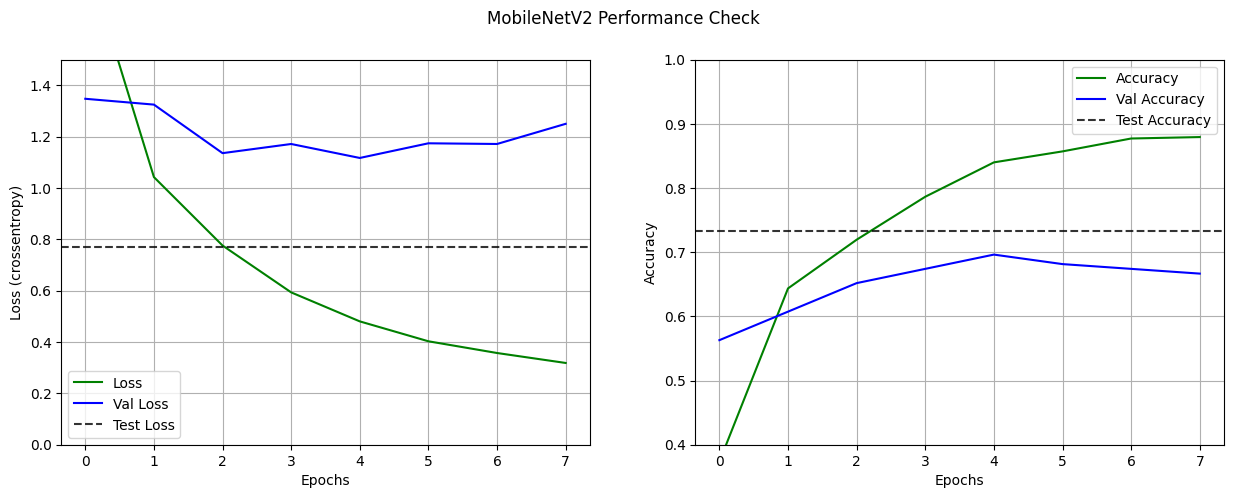

In [38]:
# Initialize the MobileNetV2 model
mobilenetv2_model = Model(model_name="MobileNetV2")

# Train the model
mobilenetv2_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
mobilenetv2_model.evaluate(testXs, testYs, visualize=True, verbose=0)

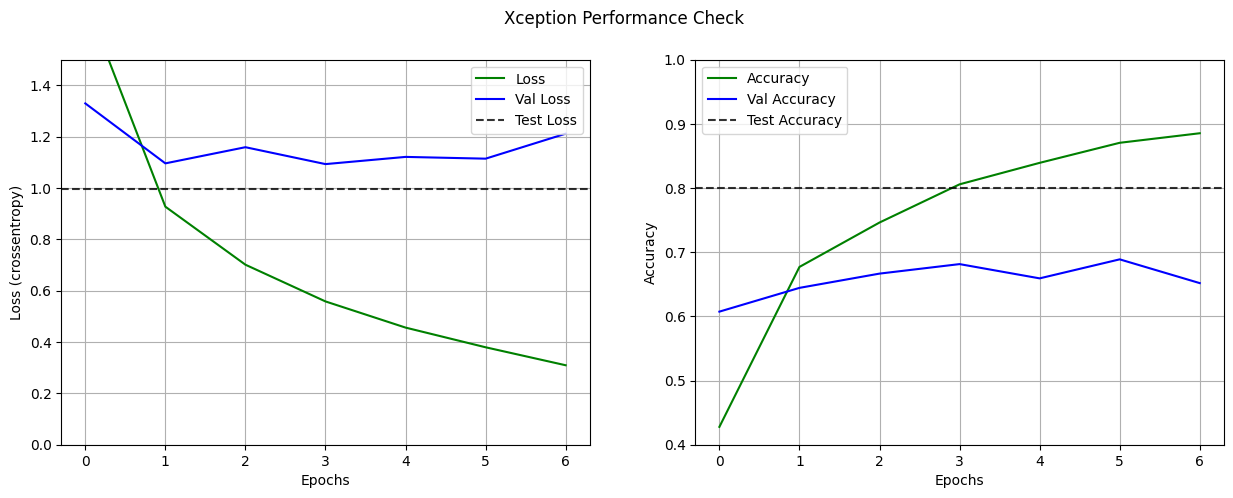

In [39]:
# Initialize the Xception model
xception_model = Model(model_name="Xception")

# Train the model
xception_model.train(
    trainXs, trainYs,
    validation_data=(validXs, validYs),
    verbose=0,
)

# Evaluate model performance on testing data.
xception_model.evaluate(testXs, testYs, visualize=True, verbose=0)

**Hypertuning**

We were able to successfully search for the best backbone that can be used for a fine and model. And this backbone is the exception model. This is because this model performed exceptionally well with the other models in comparison. Although one thing that I have noticed is that, because of the lack of images, the. is a slight difficulty to train the models, although we will try our best to perform hypertuning and make this model more robust. Improve its performance and make it applicable on the real world data. It already. shows promising results. Thus we are expecting it to show and improve the performance

In [40]:
def build_model(hp):

    model_base = Xception(include_top=False, weights="imagenet", input_shape=IMAGE_SIZE)
    model_base.trainable = True

    model = Sequential([
        model_base,
        GlobalAveragePooling2D(),
        Dropout(hp.Choice("rate", [0.4, 0.5])),
    ])

    for _ in range(hp.Choice("n_layers", [1, 2, 3])):
        model.add(
            Dense(hp.Choice("Units", [128, 256, 1024]), activation="relu"),
        )
    model.add(Dense(N_CLASSES, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-4, 1e-6])),
        metrics=['accuracy']
    )

    return model

In [41]:
def build_model(hp):
    # Create your model architecture here
    model = ...

    # Compile the model with hyperparameters
    model.compile(...)

    return model

In [11]:
from kerastuner.tuners import Hyperband

kt = Hyperband(
    build_model,
    max_epochs=10,
    objective='val_accuracy',
    project_name="XceptionHS",
    overwrite=True,
    factor=5
)
kt.search(trainXs, trainYs, validation_data=(validXs, validYs))

NameError: ignored

In [9]:
# Extract the Best Model
best_model = kt.get_best_models()[0]

# The best model architecture
best_model.summary()

NameError: ignored